In [1]:
import torch

In [2]:
# === デバイス設定 ===
# CUDA (GPU) が利用可能ならGPUを、そうでなければCPUを使用
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPUを利用します: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPUを利用します")

# === ハイパーパラメータ ===
s_0 = 100.0  # 初期細胞密度（float型を使用）

l_A = 1.0  # 面積エネルギー項の係数λ_A
l_L = 1.0  # 周囲長エネルギー項の係数λ_L (注意: TF版のcalc_cpm_percentでは未使用だった)
A_0 = 10.0  # 目標細胞面積 A_0
L_0 = 42.0  # 目標細胞周囲長 L_0 (注意: TF版のcalc_cpm_percentでは未使用だった)

T = 1.0  # 温度パラメータ T (ボルツマン分布の計算に使用)


GPUを利用します: NVIDIA H100 PCIe


In [3]:
from CPM import *

GPUを利用します: NVIDIA H100 PCIe


初期マップ（中央部分）:


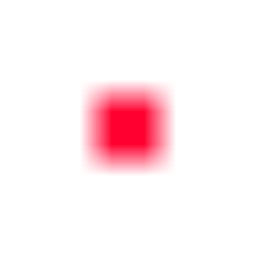

動画を cpm_torch_jp.mp4 に記録します。
map shape  torch.Size([8, 8, 3])


エポック:   0%|          | 0/20 [00:00<?, ?it/s]

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 5.6508e-07, 5.6508e-07, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]],
       device='cuda:0')
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 5.6508e-07, 0.0000e+00, 5.6508e-07, 1.0000e+

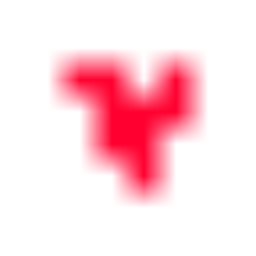

エポック:   5%|▌         | 1/20 [00:00<00:02,  8.75it/s]

密度マップ（中央部分、自動範囲）:
フレーム 1 の動画への追加中にエラー: moviepy.video.io.ffmpeg_writer.FFMPEG_VideoWriter() got multiple values for keyword argument 'filename'


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0124, 0.0000, 0.9876],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.2500, 0.7500],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0017, 0.0017, 0.0017, 0.9949],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.000

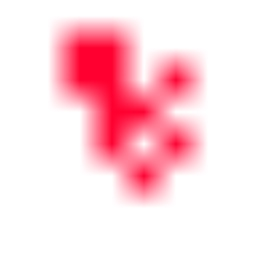

密度マップ（中央部分、自動範囲）:


tensor([[0.0000, 0.0000, 0.0920, 0.0000, 0.9080],
        [0.0000, 0.0920, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0920, 0.0920, 0.0920, 0.6321],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0124, 0.0000, 0.9876],
        [0.2500, 0.0000, 0.2500, 0.0000, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.2500, 0.2500, 0.2500, 0.2500],
        [0.0000, 0.0124, 0.0000, 0.0000, 0.9876],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.092

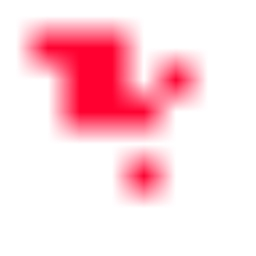

密度マップ（中央部分、自動範囲）:


tensor([[0.0920, 0.0920, 0.0000, 0.0920, 0.7241],
        [0.0000, 0.0920, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0000, 0.0000, 0.0920, 0.8161],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0124, 0.0000, 0.9876],
        [0.2500, 0.0000, 0.2500, 0.0000, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0124, 0.0000, 0.0124, 0.0000, 0.9751],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.092

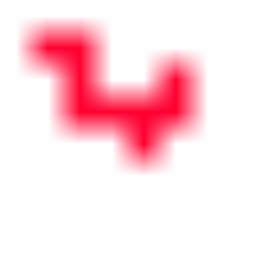

密度マップ（中央部分、自動範囲）:


tensor([[0.0124, 0.0124, 0.0000, 0.0124, 0.9627],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0124, 0.0124, 0.0124, 0.9627],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.2500, 0.0000, 0.7500],
        [0.0000, 0.2500, 0.0000, 0.0000, 0.7500],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.2500, 0.0000, 0.2500, 0.0000, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.012

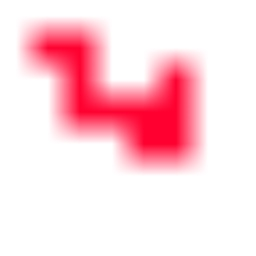

密度マップ（中央部分、自動範囲）:


tensor([[0.0920, 0.0920, 0.0000, 0.0920, 0.7241],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0920, 0.0000, 0.0920, 0.8161],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0920, 0.0000, 0.9080],
        [0.0000, 0.0920, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0000, 0.0920, 0.0000, 0.8161],
        [0.0000, 0.0920, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.092

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0124, 0.0000, 0.9876],
        [0.0000, 0.0124, 0.0124, 0.0124, 0.9627],
        [0.0000, 0.0124, 0.0000, 0.0000, 0.9876],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.2500, 0.2500, 0.5000],
        [0.2500, 0.0000, 0.0000, 0.0000, 0.7500],
        [0.0000, 0.0000, 0.0000,

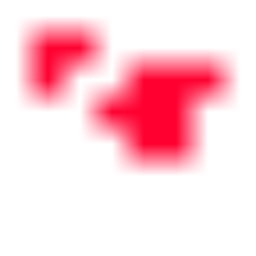

密度マップ（中央部分、自動範囲）:


tensor([[0.2500, 0.2500, 0.0000, 0.0000, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0124, 0.9876],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.2500, 0.0000, 0.2500, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0920, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0920, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0000, 0.0920, 0.0000, 0.8161],
        [0.0000, 0.0920, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.092

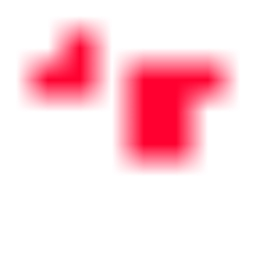

エポック:  35%|███▌      | 7/20 [00:00<00:00, 35.90it/s]

密度マップ（中央部分、自動範囲）:


tensor([[0.0000, 0.0000, 0.0920, 0.0920, 0.8161],
        [0.0000, 0.0000, 0.0000, 0.0920, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0920, 0.0000, 0.0920, 0.8161],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0920, 0.0000, 0.9080],
        [0.0000, 0.0920, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0920, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0920, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.250

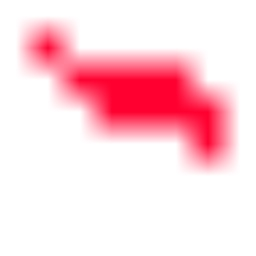

密度マップ（中央部分、自動範囲）:


tensor([[0.0920, 0.0920, 0.0920, 0.0920, 0.6321],
        [0.0000, 0.0000, 0.0000, 0.0920, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0000, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0920, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0920, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0920, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0000, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0920, 0.0920, 0.0920, 0.7241],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.000

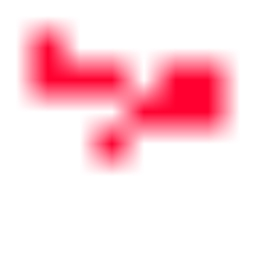

密度マップ（中央部分、自動範囲）:


tensor([[0.0920, 0.0920, 0.0920, 0.0000, 0.7241],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0920, 0.0000, 0.0000, 0.8161],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0920, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0920, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0920, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0920, 0.0920, 0.0920, 0.6321],
        [0.0920, 0.0000, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.000

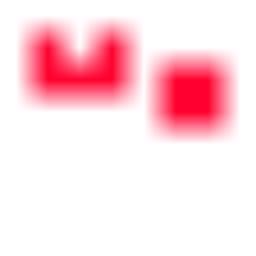

密度マップ（中央部分、自動範囲）:


tensor([[0.0124, 0.0124, 0.0124, 0.0000, 0.9627],
        [0.0000, 0.2500, 0.0000, 0.0000, 0.7500],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.2500, 0.0000, 0.7500],
        [0.0124, 0.0124, 0.0124, 0.0000, 0.9627],
        [0.0000, 0.0000, 0.0000, 0.2500, 0.7500],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.2500, 0.0000, 0.0000, 0.0000, 0.7500],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0124, 0.0000, 0.9876],
        [0.000

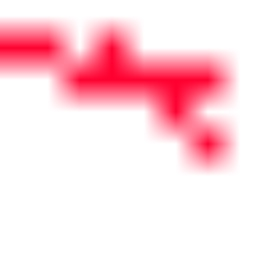

密度マップ（中央部分、自動範囲）:


tensor([[0.0920, 0.0000, 0.0920, 0.0920, 0.7241],
        [0.0000, 0.0920, 0.0000, 0.0920, 0.8161],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0920, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.2500, 0.2500, 0.0000, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.0000, 0.0000, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0124, 0.9876],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.000

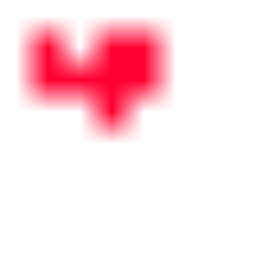

密度マップ（中央部分、自動範囲）:


tensor([[0.0017, 0.0017, 0.0017, 0.0000, 0.9949],
        [0.0017, 0.0000, 0.0017, 0.0000, 0.9966],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.2500, 0.0000, 0.7500],
        [0.0017, 0.0017, 0.0000, 0.0000, 0.9966],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.2500, 0.0000, 0.0000, 0.0000, 0.7500],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.000

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0920, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0920, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0000, 0.0920, 0.0000, 0.8161],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0920, 0.0000, 0.0920, 0.8161],
        [0.0000, 0.0000, 0.0920, 0.0920, 0.8161],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000,

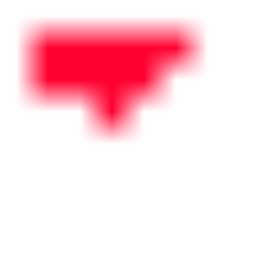

エポック:  65%|██████▌   | 13/20 [00:00<00:00, 45.19it/s]

密度マップ（中央部分、自動範囲）:


tensor([[0.0920, 0.0920, 0.0000, 0.0000, 0.8161],
        [0.0920, 0.0000, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0920, 0.0000, 0.9080],
        [0.0920, 0.0000, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0920, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0000, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0124, 0.0000, 0.9876],
        [0.250

tensor([[0.0000, 0.0000, 0.0000, 0.0124, 0.9876],
        [0.0000, 0.0000, 0.0000, 0.0124, 0.9876],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.2500, 0.0000, 0.2500, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0920, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0000, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0920, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000,

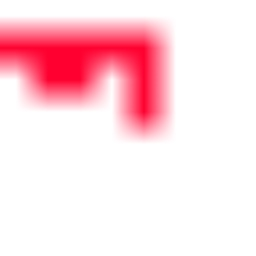

密度マップ（中央部分、自動範囲）:


tensor([[0.0124, 0.0000, 0.0000, 0.0000, 0.9876],
        [0.0124, 0.0000, 0.0124, 0.0000, 0.9751],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.2500, 0.0000, 0.0000, 0.0000, 0.7500],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0920, 0.0920, 0.0000, 0.0920, 0.7241],
        [0.0920, 0.0000, 0.0000, 0.0920, 0.8161],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0920, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.2500, 0.0000, 0.7500],
        [0.012

tensor([[0.0000, 0.0000, 0.0000, 0.0920, 0.9080],
        [0.0000, 0.0000, 0.0920, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0920, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0124, 0.0124, 0.9751],
        [0.0000, 0.0124, 0.0000, 0.0000, 0.9876],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0124, 0.0000, 0.0000, 0.0000, 0.9876],
        [0.0000, 0.0124, 0.0000, 0.0000, 0.9876],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000,

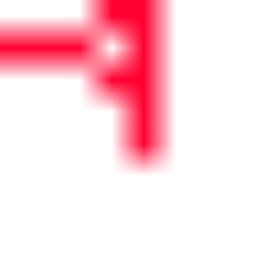

密度マップ（中央部分、自動範囲）:


tensor([[0.0920, 0.0000, 0.0000, 0.0920, 0.8161],
        [0.0000, 0.0920, 0.0920, 0.0000, 0.8161],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0920, 0.0920, 0.0920, 0.7241],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0920, 0.0920, 0.0000, 0.0920, 0.7241],
        [0.0920, 0.0920, 0.0920, 0.0920, 0.6321],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0920, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.012

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0920, 0.0000, 0.0920, 0.7241],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0000, 0.0920, 0.0000, 0.8161],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.2500, 0.7500],
        [0.0000, 0.2500, 0.0000, 0.0000, 0.7500],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.2500, 0.0000, 0.2500, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000,

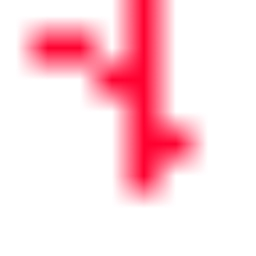

密度マップ（中央部分、自動範囲）:


tensor([[0.0920, 0.0920, 0.0000, 0.0920, 0.7241],
        [0.0000, 0.0920, 0.0920, 0.0000, 0.8161],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0920, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.2500, 0.2500, 0.2500, 0.2500],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.2500, 0.0000, 0.7500],
        [0.0000, 0.2500, 0.0000, 0.0000, 0.7500],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.092

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.2500, 0.2500, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.2500, 0.0000, 0.2500, 0.0000, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0920, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0920, 0.0000, 0.9080],
        [0.0000, 0.0920, 0.0000, 0.0920, 0.8161],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000,

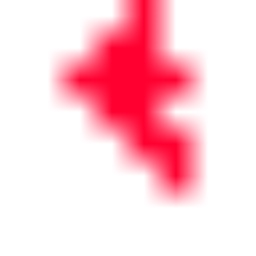

密度マップ（中央部分、自動範囲）:


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.2500, 0.0000, 0.7500],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.2500, 0.0000, 0.2500, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.2500, 0.2500, 0.0000, 0.0000, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0017, 0.0000, 0.0017, 0.0000, 0.9966],
        [0.0000, 0.0017, 0.0000, 0.0000, 0.9983],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.000

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0124, 0.9876],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.2500, 0.0000, 0.2500, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0000, 0.0000, 0.0000, 0.9080],
        [0.0920, 0.0920, 0.0000, 0.0920, 0.7241],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0000, 0.0000,

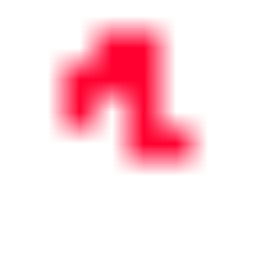

密度マップ（中央部分、自動範囲）:


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0124, 0.0000, 0.0124, 0.0000, 0.9751],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0124, 0.0000, 0.0124, 0.9751],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0124, 0.0124, 0.0000, 0.0000, 0.9751],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.2500, 0.0000, 0.7500],
        [0.0000, 0.2500, 0.0000, 0.0000, 0.7500],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.000

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0920, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0920, 0.0920, 0.0920, 0.6321],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0920, 0.0920, 0.0920, 0.7241],
        [0.0000, 0.0920, 0.0000, 0.0920, 0.8161],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000,

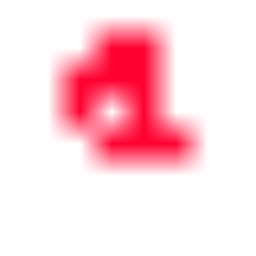

エポック:  95%|█████████▌| 19/20 [00:00<00:00, 49.36it/s]

密度マップ（中央部分、自動範囲）:


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0000, 0.0920, 0.0000, 0.8161],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0920, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0920, 0.0000, 0.0000, 0.8161],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0920, 0.0000, 0.0920, 0.7241],
        [0.0000, 0.0920, 0.0000, 0.0000, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.000

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0920, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0920, 0.0000, 0.9080],
        [0.0000, 0.0920, 0.0920, 0.0000, 0.8161],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0920, 0.9080],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.0920, 0.0920, 0.0920, 0.6321],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.000

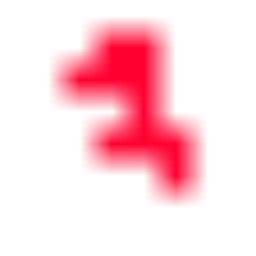

エポック: 100%|██████████| 20/20 [00:00<00:00, 44.15it/s]

密度マップ（中央部分、自動範囲）:

最終状態のマップ:


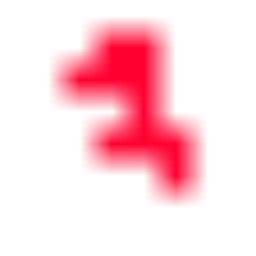


シミュレーション完了。


In [4]:
map_tensor = map_init(8,8) # マップを初期化
print("初期マップ（中央部分）:")
imshow_map(map_tensor) # 初期状態を表示

num_epochs = 20      # シミュレーションのエポック数
steps_per_epoch = 1 # 1エポックあたりのCPMステップ数
diffusion_steps = 5 # 1 CPMステップあたりの拡散ステップ数

# オプション: 動画記録用ライターの初期化
video_filename = 'cpm_torch_jp.mp4'
if moviepy_available:
    try:
        writer = LoopWriter(filename=video_filename, fps=10, fade_len=0.5) # ループ動画ライター
        print(f"動画を {video_filename} に記録します。")
        record_video = True
    except Exception as e:
        print(f"動画ライターの初期化に失敗しました: {e}")
        record_video = False
else:
    record_video = False
    print("moviepyが利用できないため、動画は記録されません。")

print("map shape ", map_tensor.shape) # マップの形状を表示
# --- シミュレーション実行 ---
for i in tqdm(range(num_epochs), desc="エポック"):
    for k in tqdm(range(steps_per_epoch), desc="CPMステップ", leave=False):

        # --- 拡散ステップ ---
        # 複数の拡散ステップを実行して密度を平滑化
        #for _ in range(diffusion_steps):
        #     map_tensor = diffusion_step(map_tensor, dt=0.1) # dtは拡散の速さ

        # --- CPM更新ステップ ---
        # チェッカーボードパターンで全セルを更新
        for x_offset in range(3): # x方向オフセット (0 or 1)
            for y_offset in range(3): # y方向オフセット (0 or 1)
                # x+y が偶数/奇数のピクセルを交互に更新するイメージ
                # ここのオフセットとパッチ抽出関数のオフセット引数の関係に注意
                # stride=2のチェッカーボード更新に対応させるため、
                # extract_patches_manual_padding_with_offset を使う。
                # オフセット(0,0), (1,0), (0,1), (1,1) で呼び出すと全ピクセルが更新される？ -> 要確認
                # 元のTFコードは slide_h, slide_w を 0, 1, 2 の範囲でループしていた？
                # ここではオフセット(0,0), (1,1) の2回で交互更新を試みる？
                # いや、(0,0), (1,0), (0,1), (1,1) で4つのサブセットを更新するのが正しいか？
                # 元のTFコードに合わせて x, y in range(3) だった？ -> range(2)で試す
                # print("time ", k, "x ", x_offset, "y ", y_offset)
                with torch.no_grad():
                  map_tensor, _ = cpm_checkerboard_step(map_tensor, l_A, A_0, l_L, L_0, T,
                                                      x_offset, y_offset)

        # 数値安定性のため、密度が負にならないようにクランプ
        map_tensor[:, :, 1].clamp_(min=0.0)

    # --- 各エポック終了時の可視化 ---
    #if ipython_available:
        #clear_output(wait=True) # 出力をクリア
    print(f"エポック {i+1}/{num_epochs}")
    print("現在のマップ（中央部分）:")
    #imshow_map(map_tensor[100:150,100:150]) # IDに基づく色表示
    imshow_map(map_tensor)
    print("密度マップ（中央部分、自動範囲）:")
    # imshow_map_area_autoRange(map_tensor[100:156, 100:156, 1]) # 密度表示

    # デバッグ情報（コメントアウト）
    # density_vals = map_tensor[:, :, 1]
    # print(f"密度統計: 最大={density_vals.max().item():.2f}, 最小={density_vals.min().item():.2f}, 合計={density_vals.sum().item():.2f}")

    # --- 動画フレーム追加 ---
    if record_video:
        try:
            # 表示用のRGB画像を生成
            ids_display = map_tensor[:, :, 0].long() % len(color_list_torch)
            frame_rgb = create_rgb_image_from_hue_tensor_pil(color_list_torch[ids_display])
            background_mask_display = (ids_display == 0)
            frame_rgb[background_mask_display] = torch.tensor([255, 255, 255], dtype=torch.uint8, device=device)
            # ライターにフレームを追加（imshowと同様、テンソルを直接渡せるようにヘルパー側で処理）
            writer.add(frame_rgb)
        except Exception as e:
            print(f"フレーム {i+1} の動画への追加中にエラー: {e}")
            record_video = False # エラーが発生したら記録を中止

# --- シミュレーション終了後 ---

# 動画ライターを閉じる
if record_video and writer:
    try:
        writer.close()
        print(f"動画を {video_filename} に保存しました。")
    except Exception as e:
        print(f"動画ライターのクローズ中にエラー: {e}")

# 最終状態を表示
print("\n最終状態のマップ:")
imshow_map(map_tensor)
# imshow_map_area_autoRange(map_tensor[:, :, 1])

print("\nシミュレーション完了。")

# --- END OF FILE CPM_torch_jp.py ---